In [98]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [99]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [100]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [101]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [102]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [103]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.004744,0.000491,0.003217,0.003817,0.008907,0.018682,0.008956,-0.009838
2005-02-01,-0.005666,-0.000115,-0.000530,-0.002013,0.006112,0.013754,0.006425,-0.003549
2005-02-02,0.004748,-0.000220,0.001214,0.005939,0.004995,0.006156,0.003192,0.002612
2005-02-03,-0.010397,-0.001690,0.000378,-0.003342,-0.007119,0.010988,-0.001758,-0.012077
2005-02-04,0.006686,0.005762,0.013300,0.005588,0.008929,0.016426,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.007921,-0.002991,-0.008365,0.018978,-0.000381,0.012039,-0.005157,0.009863
2024-12-10,-0.006082,-0.002112,-0.005163,-0.016139,-0.009207,0.002292,-0.002896,0.013155
2024-12-11,0.013895,-0.002776,-0.009999,-0.001268,0.004358,0.015587,0.007707,0.009247


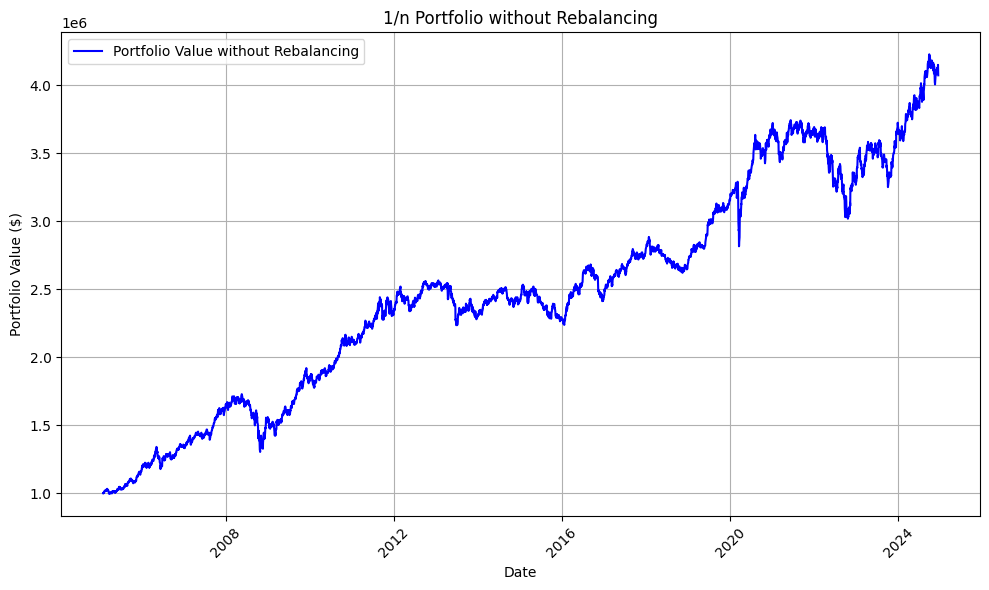

Final Portfolio Value (Non-Rebalancing): $4,073,193.49


In [104]:
#### 1/n Non-Rebalancing Portfolio Construction #### ver 2.0

weights = {
    'Japan': 1/15,
    'T-Bills_7_10': 1/6,
    'T-Bills_20': 1/6,
    'APACxJapan': 1/15,
    'Europe': 1/15,
    'LatAm': 1/15,
    'US': 1/15,
    'Gold': 1/3,
}

# Convert weights to a Series for alignment
weights_series = pd.Series(weights)

# Calculate daily portfolio returns
portfolio_return = (returns[weights_series.index] * weights_series).sum(axis=1)

# Calculate cumulative return
cumulative_return = (1 + portfolio_return).cumprod() - 1

# Initial investment
initial_investment_non_rebalancing = 1_000_000  # $1 million

# Calculate portfolio value over time (non-rebalanced)
portfolio_value_non_rebalancing = initial_investment_non_rebalancing * (1 + cumulative_return)

# Plot the portfolio value
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_non_rebalancing, label='Portfolio Value without Rebalancing', color='blue')
plt.title('1/n Portfolio without Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final portfolio value
print(f"Final Portfolio Value (Non-Rebalancing): ${portfolio_value_non_rebalancing.iloc[-1]:,.2f}")


In [105]:
#### 1/n Non-Rebalancing Portfolio Analytics #### ver 2.0

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_nonrebal = portfolio_value_non_rebalancing.resample('ME').ffill()
monthly_returns_nonrebal = monthly_portfolio_value_nonrebal.pct_change().dropna()

# 2) Full-sample monthly volatility, then annualize
full_sample_monthly_vol_nonrebal = monthly_returns_nonrebal.std()
annualized_vol_nonrebal = full_sample_monthly_vol_nonrebal * np.sqrt(12)

# 3) Total return & Geometric means
initial_val_nonrebal = portfolio_value_non_rebalancing.iloc[0]
final_val_nonrebal = portfolio_value_non_rebalancing.iloc[-1]
total_return_nonrebal = (final_val_nonrebal - initial_val_nonrebal) / initial_val_nonrebal

n_months_nonrebal = len(monthly_returns_nonrebal)
geo_avg_monthly_return_nonrebal = (final_val_nonrebal / initial_val_nonrebal) ** (1 / n_months_nonrebal) - 1
geo_avg_yearly_return_nonrebal = (1 + geo_avg_monthly_return_nonrebal) ** 12 - 1

# 4) Sharpe Ratio
arithmetic_monthly_return_nonrebal = monthly_returns_nonrebal.mean()
annualized_arithmetic_return_nonrebal = arithmetic_monthly_return_nonrebal * 12
sharpe_ratio_nonrebal = annualized_arithmetic_return_nonrebal / annualized_vol_nonrebal

# 5) Monthly 99% VaR
VaR_99_nonrebal = monthly_returns_nonrebal.quantile(1 - 0.99)

# 6) Print results
print("### 1/n Non-Rebalancing Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol_nonrebal:.4f}")
print(f"Total return: {total_return_nonrebal * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_nonrebal * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_nonrebal * 100:.2f}%")
print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_nonrebal:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_nonrebal:.4f}")


### 1/n Non-Rebalancing Portfolio Analytics ###
Full-sample annualized monthly volatility: 0.0972
Total return: 307.18%
Geometric avg monthly return (CAGR basis): 0.59%
Geometric avg yearly return (CAGR basis): 7.30%
Sharpe Ratio (Arithmetic Return / Annualized Vol): 0.78
Monthly 99% Value at Risk (VaR): -0.0582


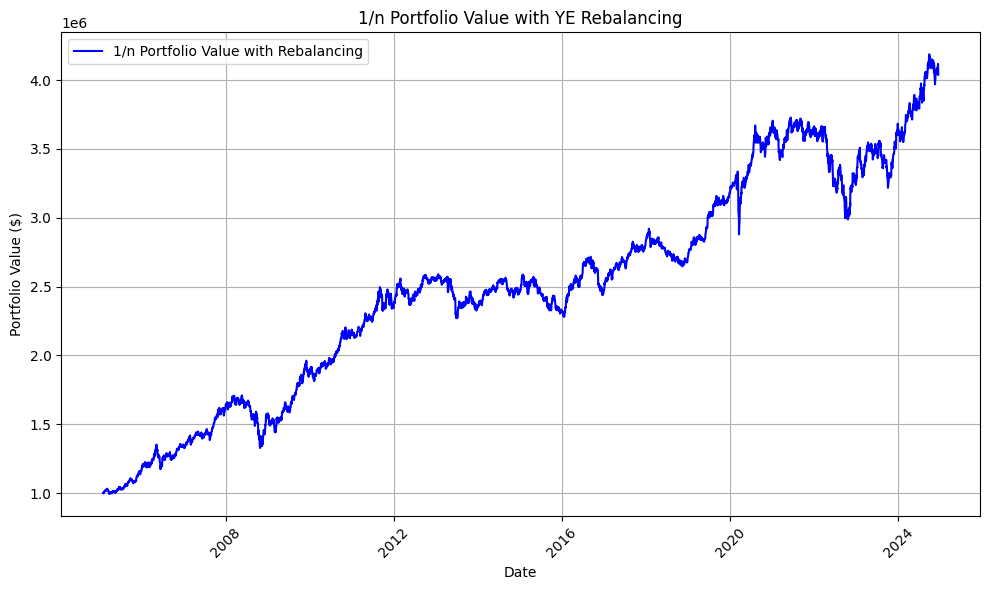

Final Portfolio Value (Rebalancing): $4,039,042.37


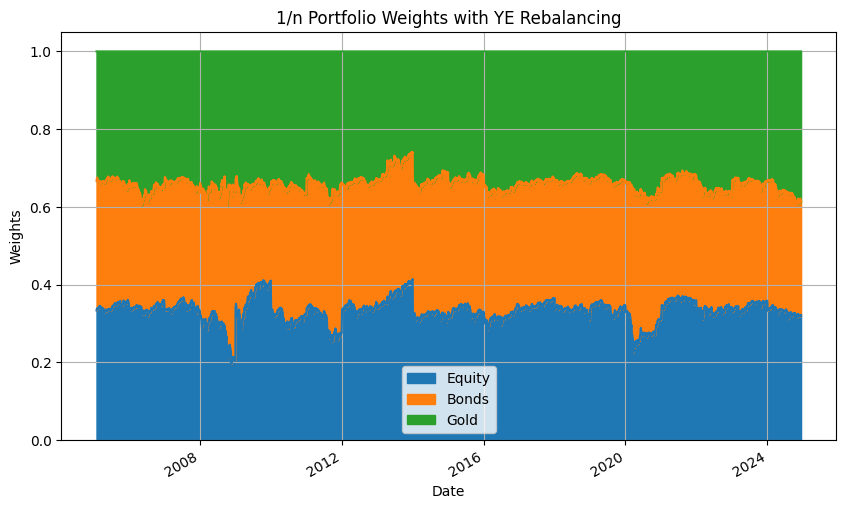

In [106]:
#### 1/n Rebalancing Portfolio Construction #### v3.0

# Define rebalancing frequency
n_frequency_rebalancing = 'YE'  # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly

# Define asset-class weights
asset_class_weights_rebalancing = {
    'equities': 1/3,
    'bonds': 1/3,
    'gold': 1/3,
}

# Define equity and bond sub-weights
equity_weights_rebalancing = {
    'Japan':      1/15,
    'APACxJapan': 1/15,
    'Europe':     1/15,
    'LatAm':      1/15,
    'US':         1/15,
}
bond_weights_rebalancing = {
    'T-Bills_7_10': 1/6,
    'T-Bills_20':   1/6,
}

# Create combined returns for each major asset class
returns_equity = returns[['Japan','APACxJapan','Europe','LatAm','US']].mean(axis=1)
returns_bonds  = returns[['T-Bills_7_10','T-Bills_20']].mean(axis=1)
returns_gold   = returns['Gold']

# Determine rebalancing dates
rebal_dates_rebalancing = returns.resample(n_frequency_rebalancing).last().index
aligned_rebal_dates = returns.index.get_indexer(rebal_dates_rebalancing, method='nearest')
rebal_dates_rebalancing = returns.index[aligned_rebal_dates]

# Initialize daily portfolio value
initial_investment_rebalancing = 1_000_000
portfolio_value_rebalancing = pd.Series(index=returns.index, dtype=float)
portfolio_value_rebalancing.iloc[0] = initial_investment_rebalancing

# Split the initial investment according to 1/3 each
initial_investment_equity = initial_investment_rebalancing * asset_class_weights_rebalancing['equities']
initial_investment_bonds  = initial_investment_rebalancing * asset_class_weights_rebalancing['bonds']
initial_investment_gold   = initial_investment_rebalancing * asset_class_weights_rebalancing['gold']

equity_value_rebalancing = pd.Series(index=returns.index, dtype=float)
bonds_value_rebalancing  = pd.Series(index=returns.index, dtype=float)
gold_value_rebalancing   = pd.Series(index=returns.index, dtype=float)

equity_value_rebalancing.iloc[0] = initial_investment_equity
bonds_value_rebalancing.iloc[0]  = initial_investment_bonds
gold_value_rebalancing.iloc[0]   = initial_investment_gold

# For tracking daily weights
equity_weights = pd.Series(index=returns.index, dtype=float)
bonds_weights  = pd.Series(index=returns.index, dtype=float)
gold_weights   = pd.Series(index=returns.index, dtype=float)

equity_weights.iloc[0] = asset_class_weights_rebalancing['equities']
bonds_weights.iloc[0]  = asset_class_weights_rebalancing['bonds']
gold_weights.iloc[0]   = asset_class_weights_rebalancing['gold']

# Portfolio rebalancing loop
for i in range(len(rebal_dates_rebalancing)):

    this_rebal_date = rebal_dates_rebalancing[i]

    # For the first iteration, use portfolio start date; otherwise, use previous rebal date
    if i == 0:
        prev_rebal_date = portfolio_value_rebalancing.index[0]
    else:
        prev_rebal_date = rebal_dates_rebalancing[i - 1]

    # Slice the daily index between prev_rebal_date and this_rebal_date
    daily_index_slice = portfolio_value_rebalancing.index[
        (portfolio_value_rebalancing.index >= prev_rebal_date) &
        (portfolio_value_rebalancing.index <= this_rebal_date)
    ]

    # Update daily portfolio values
    for d in range(1, len(daily_index_slice)):
        today = daily_index_slice[d]
        yesterday = daily_index_slice[d - 1]

        equity_value_rebalancing.loc[today] = equity_value_rebalancing.loc[yesterday] * (1 + returns_equity[today])
        bonds_value_rebalancing.loc[today]  = bonds_value_rebalancing.loc[yesterday]  * (1 + returns_bonds[today])
        gold_value_rebalancing.loc[today]   = gold_value_rebalancing.loc[yesterday]   * (1 + returns_gold[today])

        portfolio_value_rebalancing.loc[today] = (equity_value_rebalancing.loc[today]
                                                 + bonds_value_rebalancing.loc[today]
                                                 + gold_value_rebalancing.loc[today])

        equity_weights.loc[today] = equity_value_rebalancing.loc[today] / portfolio_value_rebalancing.loc[today]
        bonds_weights.loc[today]  = bonds_value_rebalancing.loc[today]  / portfolio_value_rebalancing.loc[today]
        gold_weights.loc[today]   = gold_value_rebalancing.loc[today]   / portfolio_value_rebalancing.loc[today]

    # Rebalance weights at the end of this period (except the very last period)
    if i < len(rebal_dates_rebalancing) - 1:
        # 'today' is the last day in daily_index_slice
        equity_value_rebalancing.loc[today] = portfolio_value_rebalancing.loc[today] * asset_class_weights_rebalancing['equities']
        bonds_value_rebalancing.loc[today]  = portfolio_value_rebalancing.loc[today] * asset_class_weights_rebalancing['bonds']
        gold_value_rebalancing.loc[today]   = portfolio_value_rebalancing.loc[today] * asset_class_weights_rebalancing['gold']

# Ensure the portfolio value has daily entries filled
portfolio_value_rebalancing.ffill(inplace=True)

# Combine results for convenience
portfolio_value_rebalancing = pd.concat([
    portfolio_value_rebalancing,
    equity_value_rebalancing,
    bonds_value_rebalancing,
    gold_value_rebalancing
], axis=1)

portfolio_value_rebalancing.rename(columns={
    list(portfolio_value_rebalancing)[0]: 'Portfolio',
    list(portfolio_value_rebalancing)[1]: 'Equity',
    list(portfolio_value_rebalancing)[2]: 'Bonds',
    list(portfolio_value_rebalancing)[3]: 'Gold'
}, inplace=True)

# Plot portfolio value
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_rebalancing['Portfolio'], label='1/n Portfolio Value with Rebalancing', color='blue')
plt.title(f'1/n Portfolio Value with {n_frequency_rebalancing} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Final Portfolio Value (Rebalancing): ${portfolio_value_rebalancing.iloc[-1]['Portfolio']:,.2f}")

# Plot daily weights area chart
portfolio_weights_1n = pd.concat([equity_weights, bonds_weights, gold_weights], axis=1)
portfolio_weights_1n.rename(columns={
    list(portfolio_weights_1n)[0]: 'Equity',
    list(portfolio_weights_1n)[1]: 'Bonds',
    list(portfolio_weights_1n)[2]: 'Gold'
}, inplace=True)

portfolio_weights_1n.plot(figsize=(10, 6), kind='area', stacked=True)
plt.title(f'1/n Portfolio Weights with {n_frequency_rebalancing} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


In [107]:
#### 1/n Rebalancing Portfolio Analytics #### ver 2.0

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value = portfolio_value_rebalancing['Portfolio'].resample('ME').ffill()
monthly_returns_rebalancing = monthly_portfolio_value.pct_change().dropna()

# 2) Full-sample monthly volatility, then annualize
full_sample_monthly_vol_rebalancing = monthly_returns_rebalancing.std()
annualized_vol_rebalancing = full_sample_monthly_vol_rebalancing * np.sqrt(12)

# 3) Total return & Geometric means
initial_val_rebalancing = portfolio_value_rebalancing['Portfolio'].iloc[0]
final_val_rebalancing = portfolio_value_rebalancing['Portfolio'].iloc[-1]
total_return_rebalancing = (final_val_rebalancing - initial_val_rebalancing) / initial_val_rebalancing

n_months_rebalancing = len(monthly_returns_rebalancing)
geo_avg_monthly_return_rebalancing = (final_val_rebalancing / initial_val_rebalancing) ** (1 / n_months_rebalancing) - 1
geo_avg_yearly_return_rebalancing = (1 + geo_avg_monthly_return_rebalancing) ** 12 - 1

# 4) Sharpe Ratio
arithmetic_monthly_return_rebalancing = monthly_returns_rebalancing.mean()
annualized_arithmetic_return_rebalancing = arithmetic_monthly_return_rebalancing * 12
sharpe_ratio_rebalancing = annualized_arithmetic_return_rebalancing / annualized_vol_rebalancing

# 5) Monthly 99% VaR
VaR_99_rebalancing = monthly_returns_rebalancing.quantile(1 - 0.99)

# 6) Print results
print("### 1/n Rebalancing Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol_rebalancing:.4f}")
print(f"Total return: {total_return_rebalancing * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_rebalancing * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_rebalancing * 100:.2f}%")
print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_rebalancing:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_rebalancing:.4f}")


### 1/n Rebalancing Portfolio Analytics ###
Full-sample annualized monthly volatility: 0.0973
Total return: 303.90%
Geometric avg monthly return (CAGR basis): 0.59%
Geometric avg yearly return (CAGR basis): 7.26%
Sharpe Ratio (Arithmetic Return / Annualized Vol): 0.77
Monthly 99% Value at Risk (VaR): -0.0567
